In [3]:
#!pip install pymc
#!pip install arviz
#!pip install openpyxl

In [1]:
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import arviz as az
from scipy.optimize import fmin
import openpyxl

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Przyk≈Çad z wyk≈Çadu

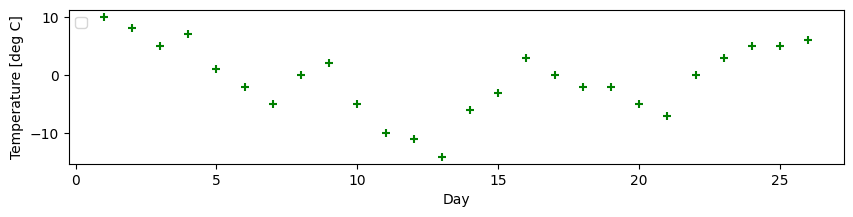

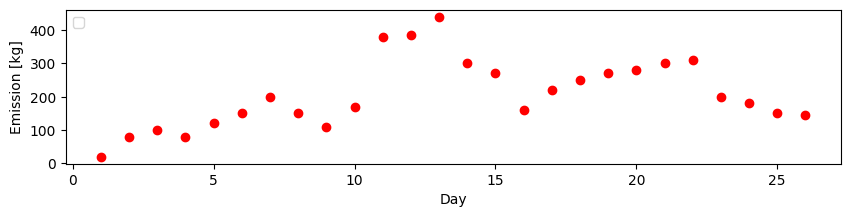

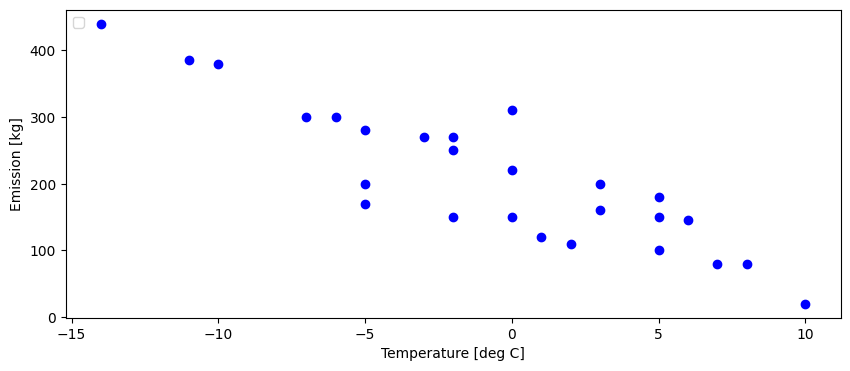

In [5]:
temperatures = [10, 8, 5, 7, 1, -2, -5, 0, 2, -5, -10, -11, -14, -6, -3, 3, 0, -2, -2, -5, -7, 0, 3, 5, 5, 6]
emissions = [20, 80, 100, 80, 120, 150, 200, 150, 110, 170, 380, 385, 440, 300, 270, 160, 220, 250, 270, 280,
          300, 310, 200, 180, 150, 145]
x_day = np.arange(1, 27, 1)

plt.figure(figsize=(10, 2))
plt.scatter(x_day, temperatures, color = 'green',marker = "+", alpha=1) #Dane empiryczne
plt.xlabel('Day')
plt.ylabel('Temperature [deg C]')
plt.legend(loc='upper left')

plt.show()

plt.figure(figsize=(10, 2))
plt.scatter(x_day, emissions, color = 'red',marker = "o", alpha=1) #Dane empiryczne
plt.xlabel('Day')
plt.ylabel('Emission [kg]')
plt.legend(loc='upper left')

plt.show()


plt.figure(figsize=(10, 4))
plt.scatter(temperatures, emissions, color = 'blue',marker = "o", alpha=1) #Dane empiryczne
plt.xlabel('Temperature [deg C]')
plt.ylabel('Emission [kg]')
plt.legend(loc='upper left')

plt.show()


Output()

Output()

/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


array([<Axes: title={'center': 'sigma_e'}>,
       <Axes: title={'center': 'b_1'}>, <Axes: title={'center': 'b_2'}>,
       <Axes: title={'center': 'tau'}>], dtype=object)

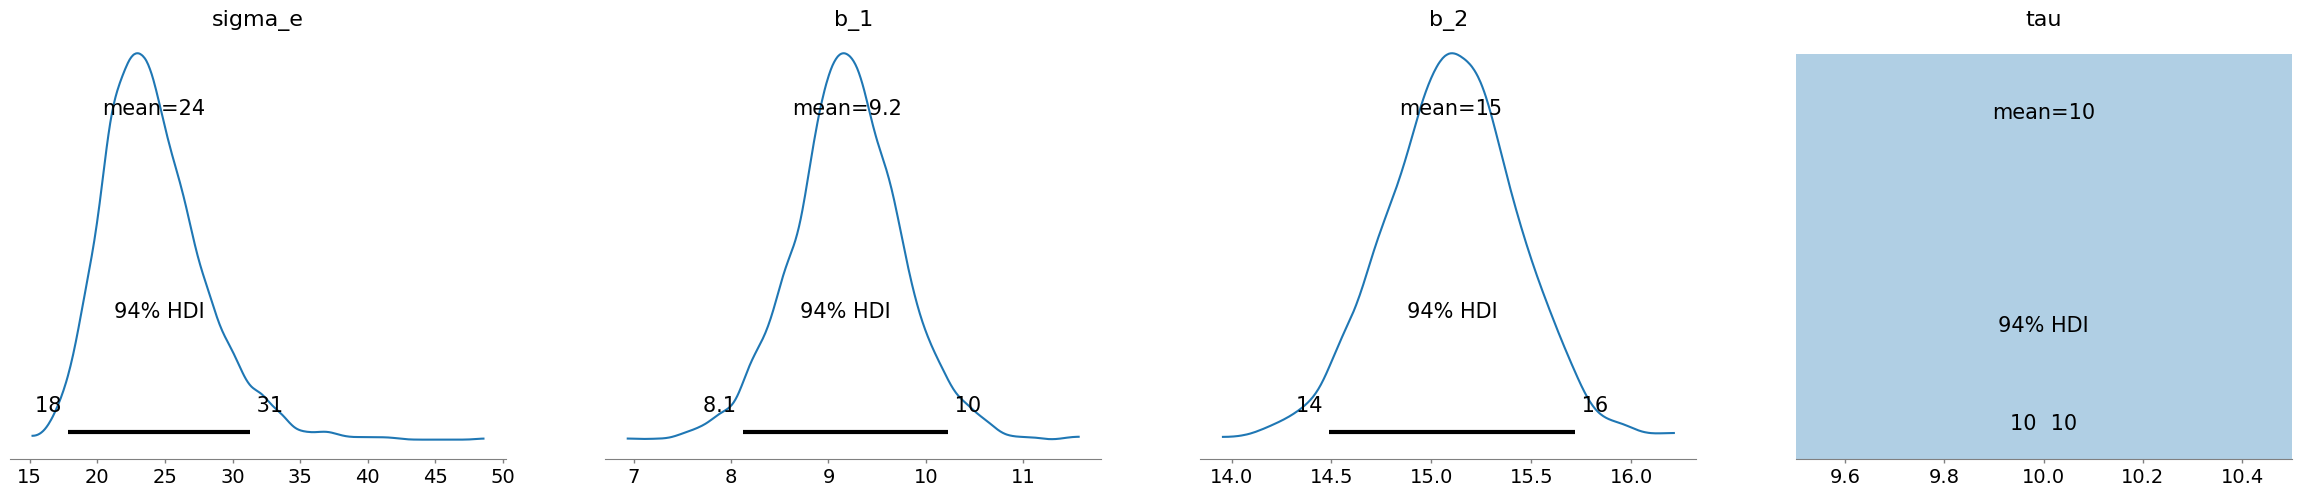

In [6]:
with pm.Model() as model:
    # Parametry modelu:
    # b_1 i b_2 to wsp√≥≈Çczynniki liniowej zale≈ºno≈õci emisji od temperatury
    b_1 = pm.Uniform("b_1", lower=0, upper=20)  # Rozk≈Çad przed punktem zmiany
    b_2 = pm.Uniform("b_2", lower=0, upper=20)  # Rozk≈Çad po punkcie zmiany

    # Punkt zmiany (dzie≈Ñ, w kt√≥rym zmienia siƒô zale≈ºno≈õƒá miƒôdzy emisjƒÖ a temperaturƒÖ)
    tau = pm.DiscreteUniform("tau", lower=0, upper=len(temperatures) - 1)

    # Tworzenie indeks√≥w dla dni
    idx = np.arange(len(temperatures))

    # Okre≈õlenie zale≈ºno≈õci emisji od temperatury w zale≈ºno≈õci od punktu zmiany
    # Je≈õli dzie≈Ñ jest przed tau, stosujemy b_1, w przeciwnym wypadku b_2
    b = pm.math.switch(tau > idx, b_1, b_2)

    # Model teoretyczny emisji
    # Emisja zwiƒôksza siƒô liniowo wraz ze spadkiem temperatury poni≈ºej 15¬∞C
    m_e = pm.Deterministic("m_e", b * 15 - b * temperatures)

    # Odchylenie standardowe b≈Çƒôdu emisji
    sigma_e = pm.Uniform("sigma_e", lower=0.1, upper=100)

    # Rozk≈Çad normalny opisujƒÖcy obserwowane emisje z uwzglƒôdnieniem szumu
    emission = pm.Normal("emission", mu=m_e, sigma=sigma_e, observed=emissions)

    # Estymacja rozk≈Çad√≥w posteriori za pomocƒÖ MCMC
    idata = pm.sample(2000, tune=2500)

az.plot_posterior(idata, var_names =["sigma_e", "b_1", "b_2", "tau"])

In [7]:
az.summary(idata,  var_names =["sigma_e", "b_1", "b_2", "tau"])

/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma_e  24.161  3.727  17.797   31.325      0.066    0.050    3619.0   
b_1       9.186  0.558   8.119   10.231      0.008    0.006    4569.0   
b_2      15.098  0.332  14.488   15.719      0.005    0.004    4046.0   
tau      10.000  0.000  10.000   10.000      0.000    0.000    4000.0   

         ess_tail  r_hat  
sigma_e    2729.0    1.0  
b_1        2877.0    1.0  
b_2        2808.0    1.0  
tau        4000.0    NaN

### Wymy≈õlony przyk≈Çad - temperatura i sprzeda≈º zimnych napoj√≥w

Jako pracownik pewnej lokalnej firmy zajmujesz siƒô nadzorowaniem sprzeda≈ºy zimnych napoj√≥w. Twoje raporty sƒÖ wykorzystywane przez dzia≈Ç sprzeda≈ºy do planowania cen produkt√≥w na kolejny sezon. Firma rozpoczyna sprzeda≈º zimnych napoj√≥w gdy temperatura wzrasta powy≈ºej 25 stopni. Lata analizy wynik√≥w firmy pokaza≈Çy, ≈ºe sprzeda≈º zimnych napoj√≥w poni≈ºej tej temperatury jest nieop≈Çacalna. Wiadomym jest, ≈ºe sprzeda≈º wzrasta liniowo wraz ze wzrostem temperatury po przekroczeniu 25 stopni. 

Masz dostƒôp do danych o temperaturze i warto≈õciach sprzeda≈ºy dla 100 dni. Chocia≈º ciep≈Ça pogoda naturalnie sprzyja≈Ça wiƒôkszemu zainteresowaniu napojami, tw√≥j zesp√≥≈Ç zauwa≈ºy≈Ç, ≈ºe w badanym okresie odnotowano wy≈ºsze warto≈õci sprzeda≈ºy ni≈º przewidywano. Dowiedzia≈Çe≈õ siƒô r√≥wnie≈º, ≈ºe w tym okresie mia≈Ço miejsce pewne wydarzenie - do miejscowo≈õci przyjecha≈Ça du≈ºa grupa turyst√≥w z Europy P√≥≈Çnocnej. Poniewa≈º nie jest pewne czy w kolejnym sezonie takie wydarzenie bƒôdzie mia≈Ço miejsce musisz uwzglƒôdniƒá to wydarzenie w swoim raporcie. Dzia≈Ç sprzeda≈ºy musi otrzymaƒá odpowiednie dane dla dw√≥ch okres√≥w, przed przybyciem turyst√≥w i po ich przyje≈∫dzie. Z tego powodu musisz ustaliƒá kiedy mia≈Ç miejsce przyjazd turyst√≥w.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

#Ziarno dla powtarzalno≈õci wynik√≥w
np.random.seed(1234)

#Liczba dni symulacji
num_days = 100

#Generowanie temperatur (temperatura od 25 do 35¬∞C)
temperatures = np.random.uniform(25, 35, 100)

#Punkt zmiany fazy (w≈Ça≈õciwy dzie≈Ñ przyjazdu turyst√≥w)
tau_true = 60

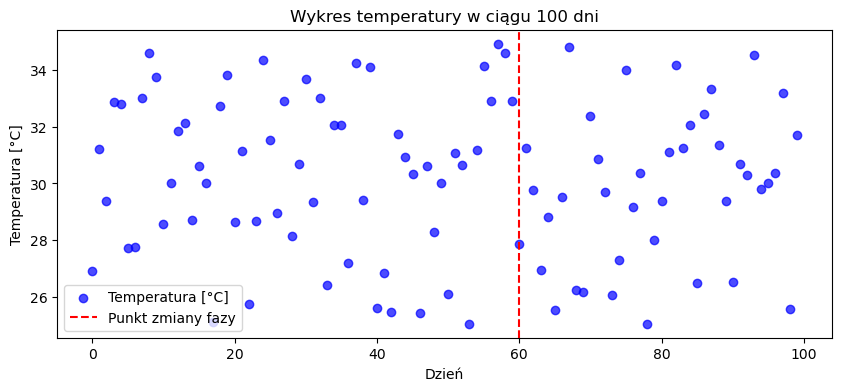

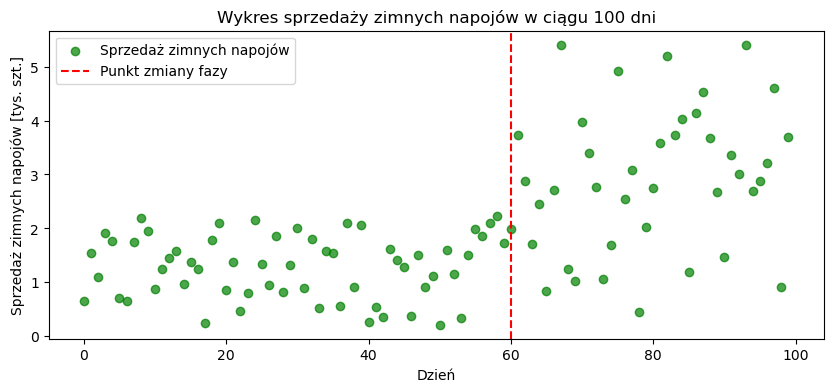

In [3]:
#Wolumen sprzeda≈ºy zimnych napoj√≥w [tys. szt.]
b_1_true = 0.2  #Wolumen sprzeda≈ºy w pierwszej fazie
b_2_true = 0.5 #Wolumen sprzeda≈ºy w drugiej fazie

#Warto≈õci sprzeda≈ºy zimnych napoj√≥w
def gen_sales(temperatures, b_1, b_2, tau, day):
    if day < tau:
        return b_1 * max(0, temperatures[day] - 24)
    else:
        return b_2 * max(0, temperatures[day] - 24)

sales = np.array([gen_sales(temperatures, b_1_true, b_2_true, tau_true, day) for day in range(num_days)])

#Dodajemy szum do danych o wzro≈õcie
sigma_sales = 0.1  #Odchylenie standardowe
sales += np.random.normal(0, sigma_sales, size=100)

#Wykres temperatury w ciƒÖgu 100 dni
plt.figure(figsize=(10, 4))
plt.scatter(range(num_days), temperatures, color='blue', alpha=0.7, label='Temperatura [¬∞C]')
plt.axvline(x=tau_true, color='red', linestyle='--', label='Punkt zmiany fazy')
plt.xlabel('Dzie≈Ñ')
plt.ylabel('Temperatura [¬∞C]')
plt.title('Wykres temperatury w ciƒÖgu 100 dni')
plt.legend()
plt.show()

#Wykres sprzeda≈ºy zimnych napoj√≥w w ciƒÖgu 100 dni
plt.figure(figsize=(10, 4))
plt.scatter(range(num_days), sales, color='green', alpha=0.7, label='Sprzeda≈º zimnych napoj√≥w')
plt.axvline(x=tau_true, color='red', linestyle='--', label='Punkt zmiany fazy')
plt.xlabel('Dzie≈Ñ')
plt.ylabel('Sprzeda≈º zimnych napoj√≥w [tys. szt.]')
plt.title('Wykres sprzeda≈ºy zimnych napoj√≥w w ciƒÖgu 100 dni')
plt.legend()
plt.show()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [b_early, b_late, sigma_sales]
>Metropolis: [tau]


d:\Programy\Anaconda\envs\python3.11.7\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_500 tune and 2_000 draw iterations (10_000 + 8_000 draws total) took 401 seconds.
d:\Programy\Anaconda\envs\python3.11.7\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


array([<Axes: title={'center': 'sigma_sales'}>,
       <Axes: title={'center': 'b_early'}>,
       <Axes: title={'center': 'b_late'}>,
       <Axes: title={'center': 'tau'}>], dtype=object)

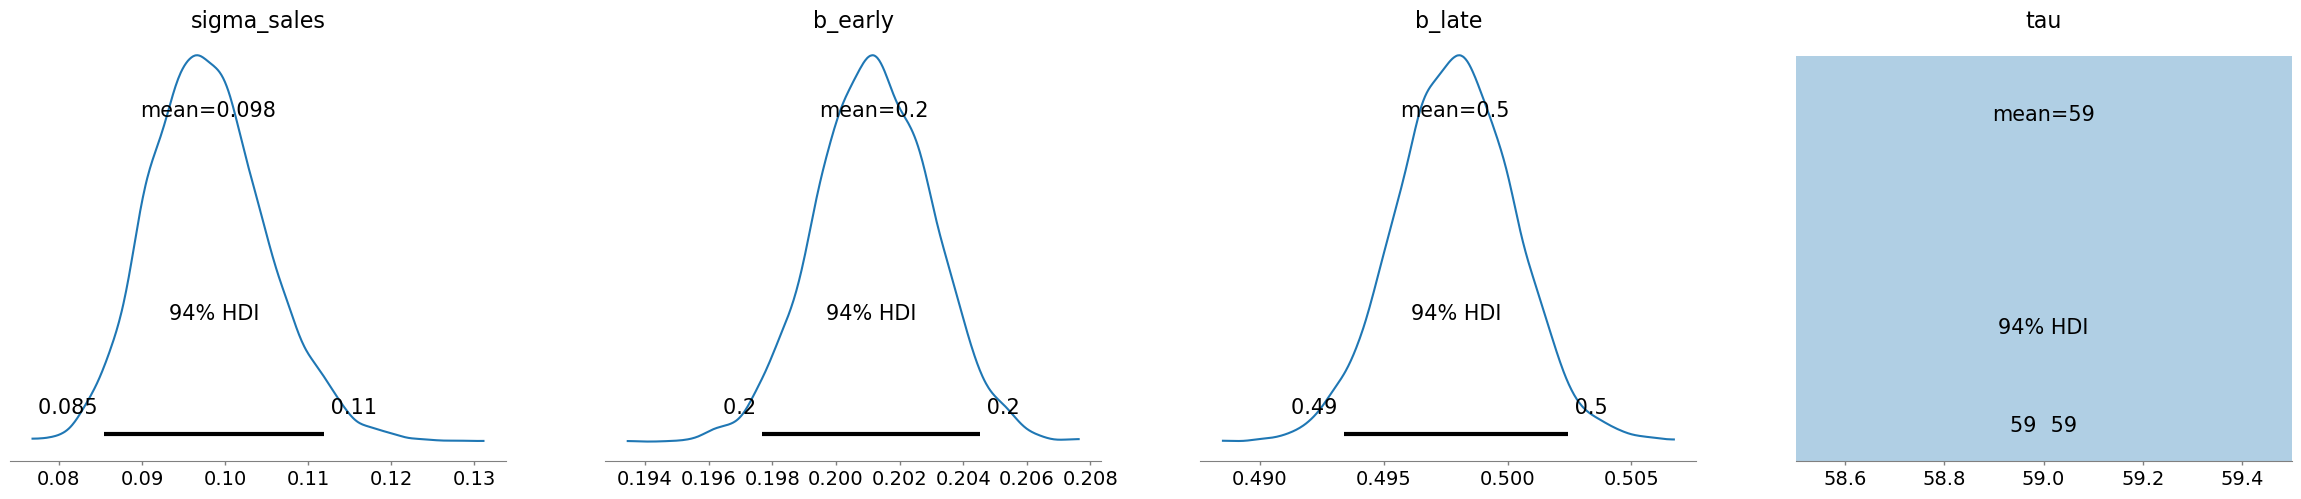

In [4]:
with pm.Model() as model:
    # Parametry modelu
    b_early = pm.Uniform("b_early", lower = 0, upper = 1)  # Wsp√≥≈Çczynnik dla dni przed 60
    b_late = pm.Uniform("b_late", lower = 0, upper = 1)  # Wsp√≥≈Çczynnik dla dni po 60

    # Punkt zmiany (dzie≈Ñ, w kt√≥rym zmienia siƒô zale≈ºno≈õƒá miƒôdzy sprzeda≈ºƒÖ a temperaturƒÖ)
    tau = pm.DiscreteUniform("tau", lower=0, upper=len(temperatures) - 1)

    # Tworzenie indeks√≥w dla dni
    idx = np.arange(len(temperatures))

    # Okre≈õlenie zale≈ºno≈õci sprzeda≈ºy od temperatury w zale≈ºno≈õci od punktu zmiany
    # Zmiana zale≈ºno≈õci sprzeda≈ºy w zale≈ºno≈õci od punktu zmiany
    b = pm.math.switch(tau < idx, b_late, b_early)

    # Modele teoretyczny sprzeda≈ºy
    # Sprzeda≈º zwiƒôksza siƒô liniowo wraz ze wzrostem temperatury powy≈ºej 25¬∞C
    # Zmienna deterministyczna, liniowo zale≈ºna od r√≥≈ºnicy miƒôdzy sta≈ÇƒÖ 25 a warto≈õciami w wektorze temperatur
    m_sales = pm.Deterministic("m_sales", b * pm.math.maximum(0, temperatures - 24))
    # m_sales = b * (temperatures - 25)
    # tzn. wraz ze wzrostem temperatury ro≈õnie sprzeda≈º zimnych napoj√≥w

    # Odchylenie standardowe (b≈ÇƒÖd w pomiarze sprzeda≈ºy)
    sigma_sales = pm.Uniform("sigma_sales", lower=0, upper=10)

    # Rozk≈Çad normalny dla obserwowanych danych sprzeda≈ºy
    sales_data = pm.Normal("sales_data", mu=m_sales, sigma=sigma_sales, observed=sales)

    # Estymacja rozk≈Çad√≥w posteriori za pomocƒÖ MCMC
    idata = pm.sample(2000, tune=2500)

az.plot_posterior(idata, var_names =["sigma_sales", "b_early", "b_late", "tau"])

In [6]:
az.summary(idata,  var_names =["sigma_sales", "b_early", "b_late", "tau"])

d:\Programy\Anaconda\envs\python3.11.7\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma_sales   0.098  0.007   0.085    0.112        0.0      0.0   11452.0   
b_early       0.201  0.002   0.198    0.205        0.0      0.0   12946.0   
b_late        0.498  0.002   0.493    0.502        0.0      0.0   11037.0   
tau          59.000  0.000  59.000   59.000        0.0      0.0    8000.0   

             ess_tail  r_hat  
sigma_sales    6048.0    1.0  
b_early        6036.0    1.0  
b_late         6380.0    1.0  
tau            8000.0    NaN


sigma_sales:

≈örednia: 0.098
Przedzia≈Ç HDI 94%: [0.085, 0.112]
Model ca≈Çkiem dobrze uchwyci≈Ç szum (rzeczywisty 0.1)

ùëè_early:

≈örednia: 0.201
Przedzia≈Ç HDI 94%: [0.198, 0.205]
Wolumen sprzeda≈º w pierwszej fazie zosta≈Ç oszacowany bardzo dobrze (rzeczywisty 0.2).

ùëè_late

≈örednia: 0.498
Przedzia≈Ç HDI 94%: [0.493, 0.502]
Wolumen sprzeda≈º w drugiej fazie zosta≈Ç oszacowany do≈õƒá bardzo dobrze (rzeczywisty 0.5).

tau (punkt zmiany fazy):

≈örednia i HDI: 59
Model dobrze zidentyfikowa≈Ç dzie≈Ñ przej≈õcia miƒôdzy dwiema fazami (rzeczywisty 60), co ≈õwiadczy o skuteczno≈õci w wykrywaniu strukturalnych zmian w danych.

### Mniejsza r√≥≈ºnica pomiƒôdzy wsp√≥≈Çczynnikami b

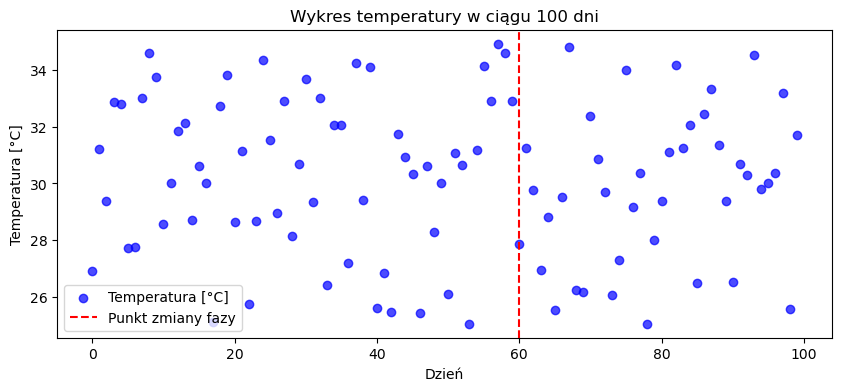

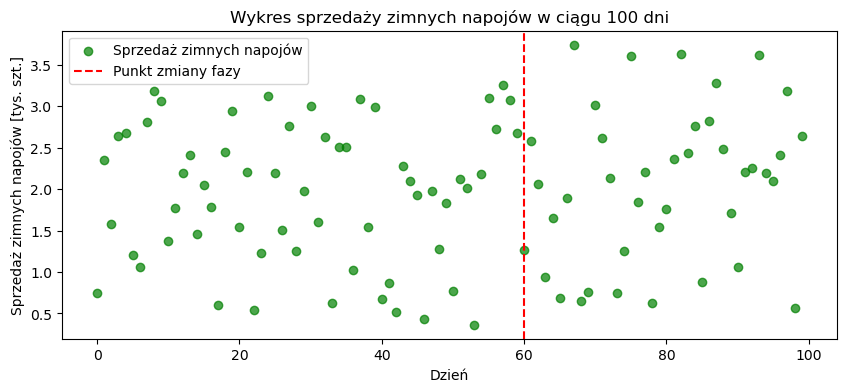

In [10]:
#Wolumen sprzeda≈ºy zimnych napoj√≥w [tys. szt.]
b_1_true = 0.3  #Wolumen sprzeda≈ºy w pierwszej fazie
b_2_true = 0.35 #Wolumen sprzeda≈ºy w drugiej fazie

#Warto≈õci sprzeda≈ºy zimnych napoj√≥w
def gen_sales(temperatures, b_1, b_2, tau, day):
    if day < tau:
        return b_1 * max(0, temperatures[day] - 24)
    else:
        return b_2 * max(0, temperatures[day] - 24)

sales = np.array([gen_sales(temperatures, b_1_true, b_2_true, tau_true, day) for day in range(num_days)])

#Dodajemy szum do danych o wzro≈õcie
sigma_sales = 0.1  #Odchylenie standardowe
sales += np.random.normal(0, sigma_sales, size=100)

#Wykres temperatury w ciƒÖgu 100 dni
plt.figure(figsize=(10, 4))
plt.scatter(range(num_days), temperatures, color='blue', alpha=0.7, label='Temperatura [¬∞C]')
plt.axvline(x=tau_true, color='red', linestyle='--', label='Punkt zmiany fazy')
plt.xlabel('Dzie≈Ñ')
plt.ylabel('Temperatura [¬∞C]')
plt.title('Wykres temperatury w ciƒÖgu 100 dni')
plt.legend()
plt.show()

#Wykres sprzeda≈ºy zimnych napoj√≥w w ciƒÖgu 100 dni
plt.figure(figsize=(10, 4))
plt.scatter(range(num_days), sales, color='green', alpha=0.7, label='Sprzeda≈º zimnych napoj√≥w')
plt.axvline(x=tau_true, color='red', linestyle='--', label='Punkt zmiany fazy')
plt.xlabel('Dzie≈Ñ')
plt.ylabel('Sprzeda≈º zimnych napoj√≥w [tys. szt.]')
plt.title('Wykres sprzeda≈ºy zimnych napoj√≥w w ciƒÖgu 100 dni')
plt.legend()
plt.show()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [b_early, b_late, sigma_sales]
>Metropolis: [tau]


d:\Programy\Anaconda\envs\python3.11.7\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_500 tune and 2_000 draw iterations (10_000 + 8_000 draws total) took 403 seconds.


array([<Axes: title={'center': 'sigma_sales'}>,
       <Axes: title={'center': 'b_early'}>,
       <Axes: title={'center': 'b_late'}>,
       <Axes: title={'center': 'tau'}>], dtype=object)

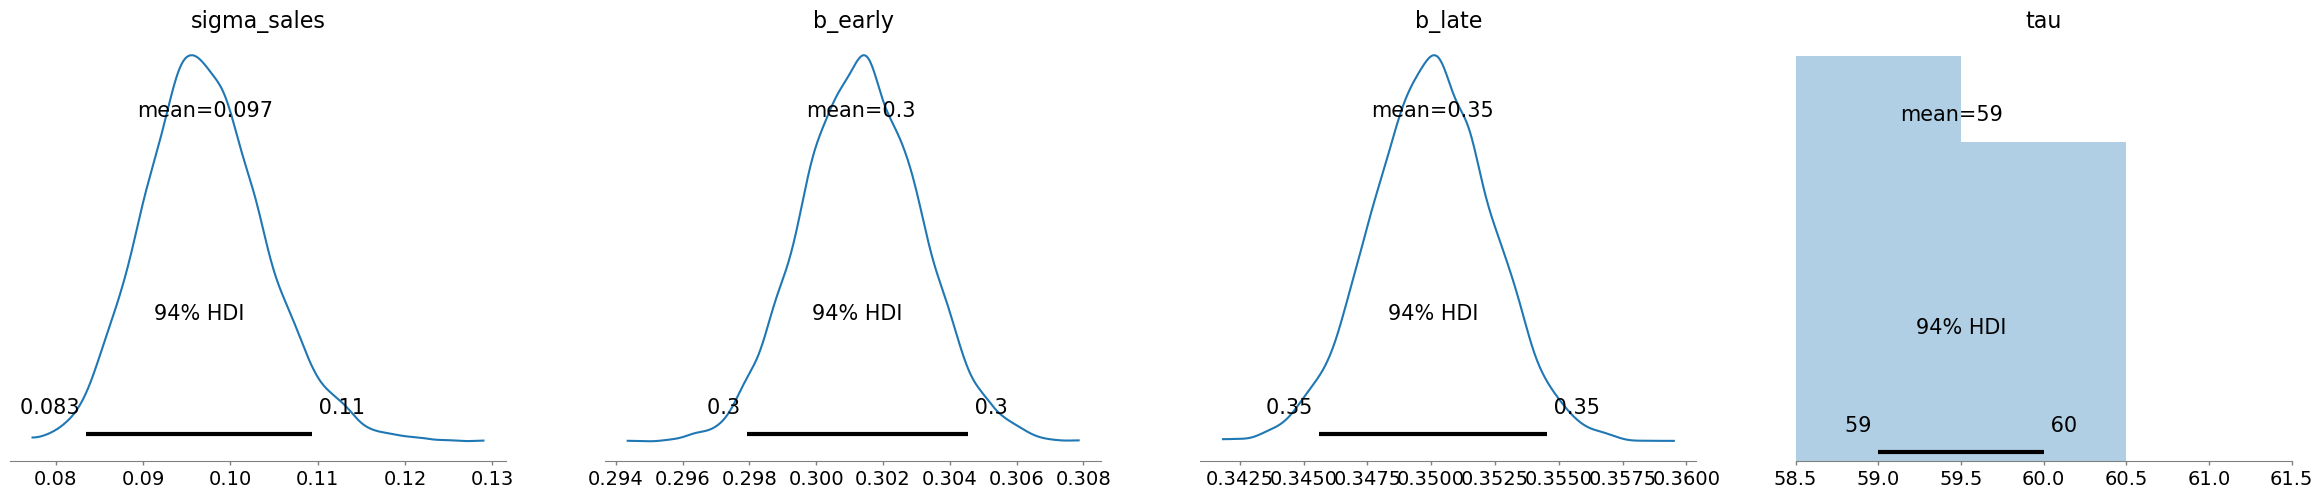

In [11]:
with pm.Model() as model:
    # Parametry modelu
    b_early = pm.Uniform("b_early", lower = 0, upper = 1)  # Wsp√≥≈Çczynnik dla dni przed 60
    b_late = pm.Uniform("b_late", lower = 0, upper = 1)  # Wsp√≥≈Çczynnik dla dni po 60

    # Punkt zmiany (dzie≈Ñ, w kt√≥rym zmienia siƒô zale≈ºno≈õƒá miƒôdzy sprzeda≈ºƒÖ a temperaturƒÖ)
    tau = pm.DiscreteUniform("tau", lower=0, upper=len(temperatures) - 1)

    # Tworzenie indeks√≥w dla dni
    idx = np.arange(len(temperatures))

    # Okre≈õlenie zale≈ºno≈õci sprzeda≈ºy od temperatury w zale≈ºno≈õci od punktu zmiany
    # Zmiana zale≈ºno≈õci sprzeda≈ºy w zale≈ºno≈õci od punktu zmiany
    b = pm.math.switch(tau < idx, b_late, b_early)

    # Modele teoretyczny sprzeda≈ºy
    # Sprzeda≈º zwiƒôksza siƒô liniowo wraz ze wzrostem temperatury powy≈ºej 25¬∞C
    # Zmienna deterministyczna, liniowo zale≈ºna od r√≥≈ºnicy miƒôdzy sta≈ÇƒÖ 25 a warto≈õciami w wektorze temperatur
    m_sales = pm.Deterministic("m_sales", b * pm.math.maximum(0, temperatures - 24))
    # m_sales = b * (temperatures - 25)
    # tzn. wraz ze wzrostem temperatury ro≈õnie sprzeda≈º zimnych napoj√≥w

    # Odchylenie standardowe (b≈ÇƒÖd w pomiarze sprzeda≈ºy)
    sigma_sales = pm.Uniform("sigma_sales", lower=0, upper=10)

    # Rozk≈Çad normalny dla obserwowanych danych sprzeda≈ºy
    sales_data = pm.Normal("sales_data", mu=m_sales, sigma=sigma_sales, observed=sales)

    # Estymacja rozk≈Çad√≥w posteriori za pomocƒÖ MCMC
    idata = pm.sample(2000, tune=2500)

az.plot_posterior(idata, var_names =["sigma_sales", "b_early", "b_late", "tau"])

In [12]:
az.summary(idata,  var_names =["sigma_sales", "b_early", "b_late", "tau"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma_sales   0.097  0.007   0.083    0.109      0.000    0.000   10181.0   
b_early       0.301  0.002   0.298    0.305      0.000    0.000   10656.0   
b_late        0.350  0.002   0.346    0.355      0.000    0.000   11623.0   
tau          59.441  0.497  59.000   60.000      0.011    0.008    1955.0   

             ess_tail  r_hat  
sigma_sales    5897.0    1.0  
b_early        5754.0    1.0  
b_late         6027.0    1.0  
tau            1951.0    1.0

sigma_sales:

≈örednia: 0.097
Przedzia≈Ç HDI 94%: [0.083, 0.109]
Model ca≈Çkiem dobrze uchwyci≈Ç szum (rzeczywisty 0.1)

ùëè_early:

≈örednia: 0.301
Przedzia≈Ç HDI 94%: [0.298, 0.305]
Wolumen sprzeda≈º w pierwszej fazie zosta≈Ç oszacowany bardzo dobrze (rzeczywisty 0.3).

ùëè_late

≈örednia: 0.350
Przedzia≈Ç HDI 94%: [0.346, 0.355]
Wolumen sprzeda≈º w drugiej fazie zosta≈Ç oszacowany do≈õƒá bardzo dobrze (rzeczywisty 0.35).

tau (punkt zmiany fazy):

≈örednia i HDI: 59.44 [59.000, 60.000]
Model bardzo dobrze zidentyfikowa≈Ç dzie≈Ñ przej≈õcia miƒôdzy dwiema fazami (rzeczywisty 60), co ≈õwiadczy o skuteczno≈õci w wykrywaniu strukturalnych zmian w danych.

### Wiƒôkszy szum

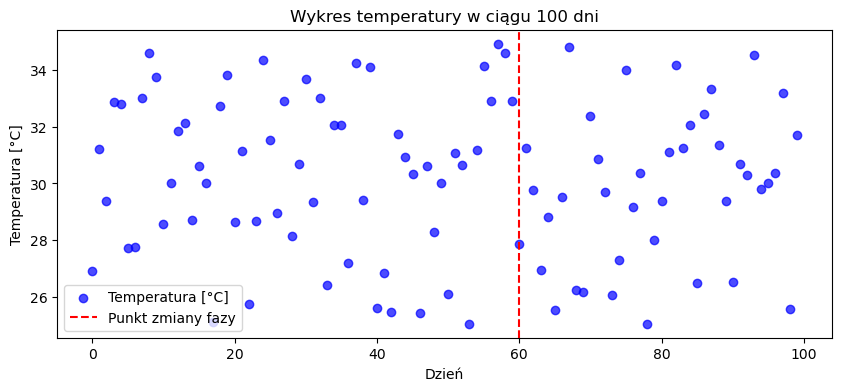

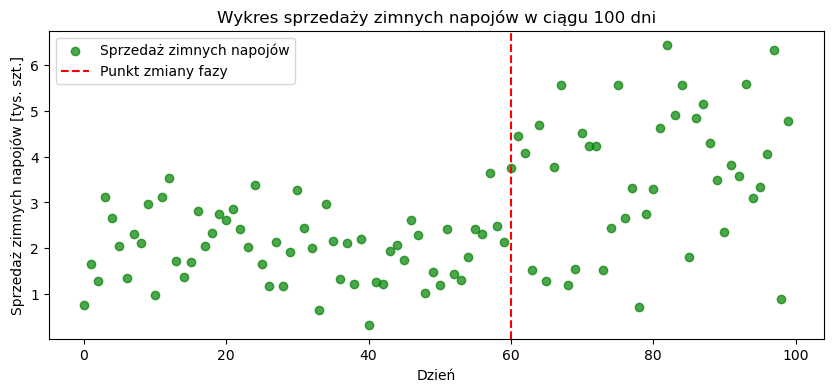

In [22]:
#Wolumen sprzeda≈ºy zimnych napoj√≥w [tys. szt.]
b_1_true = 0.2  #Wolumen sprzeda≈ºy w pierwszej fazie
b_2_true = 0.5 #Wolumen sprzeda≈ºy w drugiej fazie

#Warto≈õci sprzeda≈ºy zimnych napoj√≥w
def gen_sales(temperatures, b_1, b_2, tau, day):
    if day < tau:
        return b_1 * max(0, temperatures[day] - 24)
    else:
        return b_2 * max(0, temperatures[day] - 24)

sales = np.array([gen_sales(temperatures, b_1_true, b_2_true, tau_true, day) for day in range(num_days)])

#Dodajemy szum do danych o wzro≈õcie
sigma_sales = 0.9  #Odchylenie standardowe
sales += abs(np.random.normal(0, sigma_sales, size=100))

#Wykres temperatury w ciƒÖgu 100 dni
plt.figure(figsize=(10, 4))
plt.scatter(range(num_days), temperatures, color='blue', alpha=0.7, label='Temperatura [¬∞C]')
plt.axvline(x=tau_true, color='red', linestyle='--', label='Punkt zmiany fazy')
plt.xlabel('Dzie≈Ñ')
plt.ylabel('Temperatura [¬∞C]')
plt.title('Wykres temperatury w ciƒÖgu 100 dni')
plt.legend()
plt.show()

#Wykres sprzeda≈ºy zimnych napoj√≥w w ciƒÖgu 100 dni
plt.figure(figsize=(10, 4))
plt.scatter(range(num_days), sales, color='green', alpha=0.7, label='Sprzeda≈º zimnych napoj√≥w')
plt.axvline(x=tau_true, color='red', linestyle='--', label='Punkt zmiany fazy')
plt.xlabel('Dzie≈Ñ')
plt.ylabel('Sprzeda≈º zimnych napoj√≥w [tys. szt.]')
plt.title('Wykres sprzeda≈ºy zimnych napoj√≥w w ciƒÖgu 100 dni')
plt.legend()
plt.show()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [b_early, b_late, sigma_sales]
>Metropolis: [tau]


d:\Programy\Anaconda\envs\python3.11.7\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_500 tune and 2_000 draw iterations (10_000 + 8_000 draws total) took 374 seconds.


array([<Axes: title={'center': 'sigma_sales'}>,
       <Axes: title={'center': 'b_early'}>,
       <Axes: title={'center': 'b_late'}>,
       <Axes: title={'center': 'tau'}>], dtype=object)

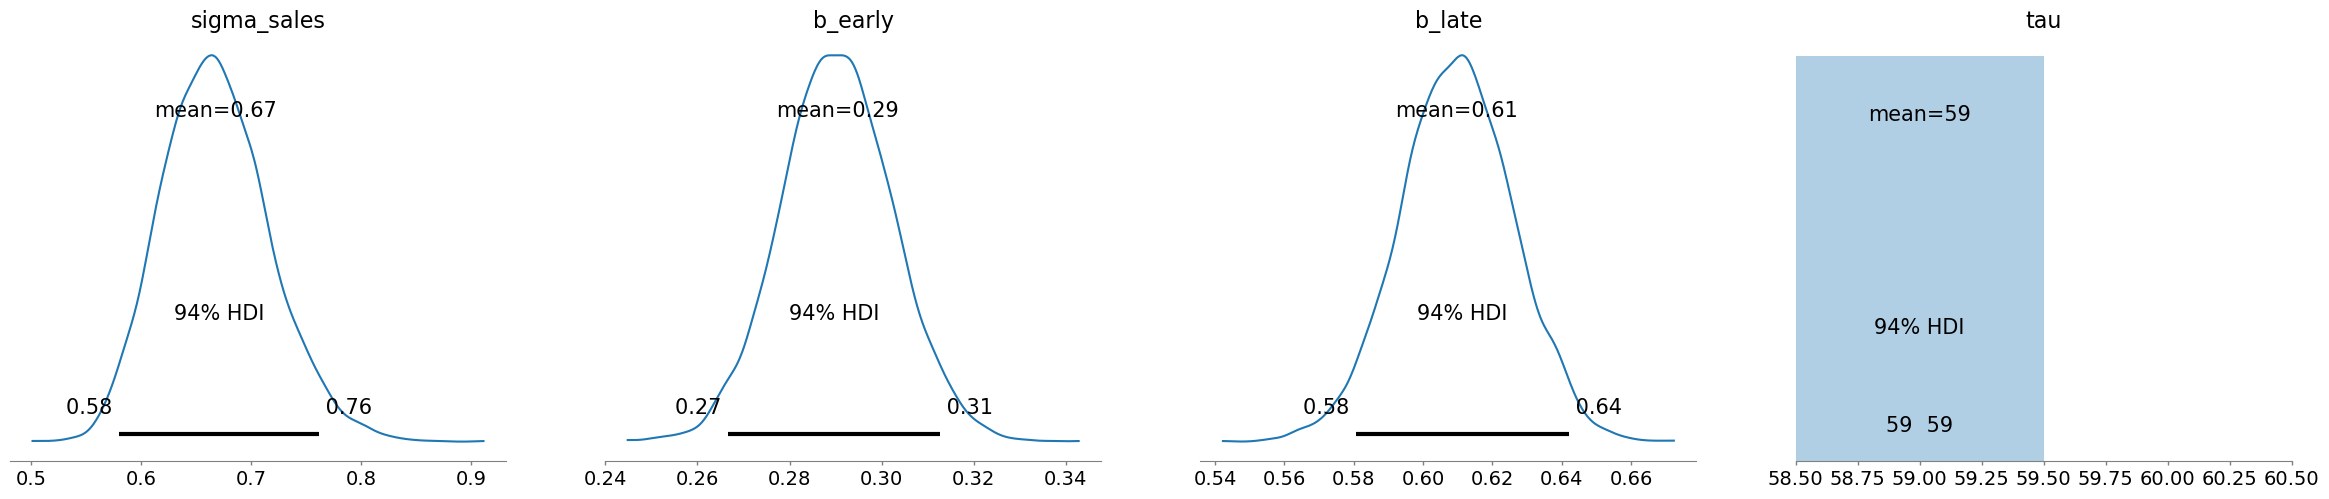

In [23]:
with pm.Model() as model:
    # Parametry modelu
    b_early = pm.Uniform("b_early", lower = 0, upper = 1)  # Wsp√≥≈Çczynnik dla dni przed 60
    b_late = pm.Uniform("b_late", lower = 0, upper = 1)  # Wsp√≥≈Çczynnik dla dni po 60

    # Punkt zmiany (dzie≈Ñ, w kt√≥rym zmienia siƒô zale≈ºno≈õƒá miƒôdzy sprzeda≈ºƒÖ a temperaturƒÖ)
    tau = pm.DiscreteUniform("tau", lower=0, upper=len(temperatures) - 1)

    # Tworzenie indeks√≥w dla dni
    idx = np.arange(len(temperatures))

    # Okre≈õlenie zale≈ºno≈õci sprzeda≈ºy od temperatury w zale≈ºno≈õci od punktu zmiany
    # Zmiana zale≈ºno≈õci sprzeda≈ºy w zale≈ºno≈õci od punktu zmiany
    b = pm.math.switch(tau < idx, b_late, b_early)

    # Modele teoretyczny sprzeda≈ºy
    # Sprzeda≈º zwiƒôksza siƒô liniowo wraz ze wzrostem temperatury powy≈ºej 25¬∞C
    # Zmienna deterministyczna, liniowo zale≈ºna od r√≥≈ºnicy miƒôdzy sta≈ÇƒÖ 25 a warto≈õciami w wektorze temperatur
    m_sales = pm.Deterministic("m_sales", b * pm.math.maximum(0, temperatures - 24))
    # m_sales = b * (temperatures - 25)
    # tzn. wraz ze wzrostem temperatury ro≈õnie sprzeda≈º zimnych napoj√≥w

    # Odchylenie standardowe (b≈ÇƒÖd w pomiarze sprzeda≈ºy)
    sigma_sales = pm.Uniform("sigma_sales", lower=0, upper=10)

    # Rozk≈Çad normalny dla obserwowanych danych sprzeda≈ºy
    sales_data = pm.Normal("sales_data", mu=m_sales, sigma=sigma_sales, observed=sales)

    # Estymacja rozk≈Çad√≥w posteriori za pomocƒÖ MCMC
    idata = pm.sample(2000, tune=2500)

az.plot_posterior(idata, var_names =["sigma_sales", "b_early", "b_late", "tau"])

In [24]:
az.summary(idata,  var_names =["sigma_sales", "b_early", "b_late", "tau"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma_sales   0.668  0.049   0.581    0.762      0.000    0.000   10191.0   
b_early       0.290  0.012   0.267    0.313      0.000    0.000   11490.0   
b_late        0.610  0.016   0.581    0.642      0.000    0.000   11434.0   
tau          59.001  0.034  59.000   59.000      0.001    0.001    1762.0   

             ess_tail  r_hat  
sigma_sales    4961.0    1.0  
b_early        6027.0    1.0  
b_late         5853.0    1.0  
tau            1762.0    1.0

sigma_sales:

≈örednia: 0.668
Przedzia≈Ç HDI 94%: [0.581, 0.762]
Model nie uchwyci≈Ç szum w pe≈Çni dobrze (rzeczywisty 0.9)

ùëè_early:

≈örednia: 0.29
Przedzia≈Ç HDI 94%: [0.267m 0.313]
Wolumen sprzeda≈º w pierwszej fazie zosta≈Ç oszacowany na wiƒôkszy ni≈º w rzeczywisto≈õci (rzeczywisty 0.2).

ùëè_late

≈örednia: 0.61
Przedzia≈Ç HDI 94%: [0.581, 0.642]
Wolumen sprzeda≈º w drugiej fazie zosta≈Ç oszacowany na wiƒôkszy ni≈º w rzeczywisto≈õci (rzeczywisty 0.5).

tau (punkt zmiany fazy):

≈örednia i HDI: 59
Model ca≈Çkiem dobrze zidentyfikowa≈Ç dzie≈Ñ przej≈õcia miƒôdzy dwiema fazami (rzeczywisty 60), co ≈õwiadczy o skuteczno≈õci w wykrywaniu strukturalnych zmian w danych.

### G≈Çadkie przej≈õcie pomiƒôdzy fazami

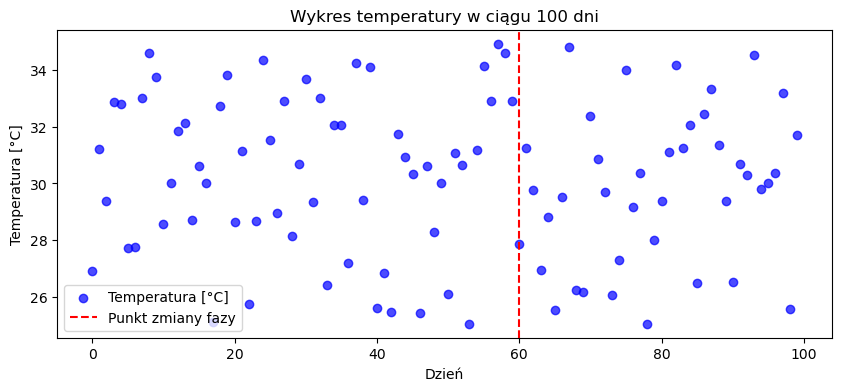

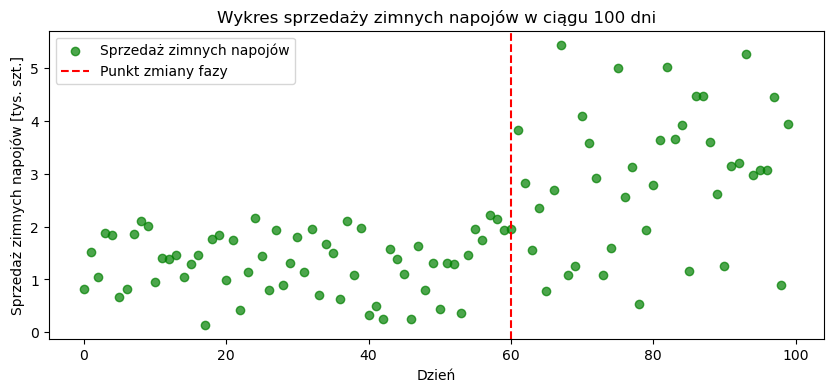

In [25]:
import numpy as np

# Wolumen sprzeda≈ºy zimnych napoj√≥w [tys. szt.]
b_1_true = 0.2  # Wolumen sprzeda≈ºy w pierwszej fazie
b_2_true = 0.5  # Wolumen sprzeda≈ºy w drugiej fazie


# Funkcja do generowania warto≈õci b w zale≈ºno≈õci od dnia
def calculate_b(day, start_day, end_day, b_start, b_end):
    if day < start_day:
        return b_start
    elif day > end_day:
        return b_end
    else:
        # Interpolacja liniowa miƒôdzy b_start a b_end
        return b_start + (b_end - b_start) * (day - start_day) / (end_day - start_day)

# Warto≈õci sprzeda≈ºy zimnych napoj√≥w
def gen_sales(temperatures, b_1, b_2, tau, day, start_day=40, end_day=60, b_start=0.2, b_end=0.5):
    if day < tau:
        return b_1 * max(0, temperatures[day] - 24)
    else:
        # Oblicz warto≈õƒá b w zakresie dni od start_day do end_day
        b_dynamic = calculate_b(day, start_day, end_day, b_start, b_end)
        return b_dynamic * max(0, temperatures[day] - 24)

# Generowanie danych sprzeda≈ºy
sales = np.array([gen_sales(temperatures, b_1_true, b_2_true, tau_true, day) for day in range(num_days)])

#Dodajemy szum do danych o wzro≈õcie
sigma_sales = 0.1  #Odchylenie standardowe
sales += np.random.normal(0, sigma_sales, size=100)

#Wykres temperatury w ciƒÖgu 100 dni
plt.figure(figsize=(10, 4))
plt.scatter(range(num_days), temperatures, color='blue', alpha=0.7, label='Temperatura [¬∞C]')
plt.axvline(x=tau_true, color='red', linestyle='--', label='Punkt zmiany fazy')
plt.xlabel('Dzie≈Ñ')
plt.ylabel('Temperatura [¬∞C]')
plt.title('Wykres temperatury w ciƒÖgu 100 dni')
plt.legend()
plt.show()

#Wykres sprzeda≈ºy zimnych napoj√≥w w ciƒÖgu 100 dni
plt.figure(figsize=(10, 4))
plt.scatter(range(num_days), sales, color='green', alpha=0.7, label='Sprzeda≈º zimnych napoj√≥w')
plt.axvline(x=tau_true, color='red', linestyle='--', label='Punkt zmiany fazy')
plt.xlabel('Dzie≈Ñ')
plt.ylabel('Sprzeda≈º zimnych napoj√≥w [tys. szt.]')
plt.title('Wykres sprzeda≈ºy zimnych napoj√≥w w ciƒÖgu 100 dni')
plt.legend()
plt.show()
plt.show()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [b_early, b_late, sigma_sales]
>Metropolis: [tau]


d:\Programy\Anaconda\envs\python3.11.7\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_500 tune and 2_000 draw iterations (10_000 + 8_000 draws total) took 392 seconds.
d:\Programy\Anaconda\envs\python3.11.7\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


array([<Axes: title={'center': 'sigma_sales'}>,
       <Axes: title={'center': 'b_early'}>,
       <Axes: title={'center': 'b_late'}>,
       <Axes: title={'center': 'tau'}>], dtype=object)

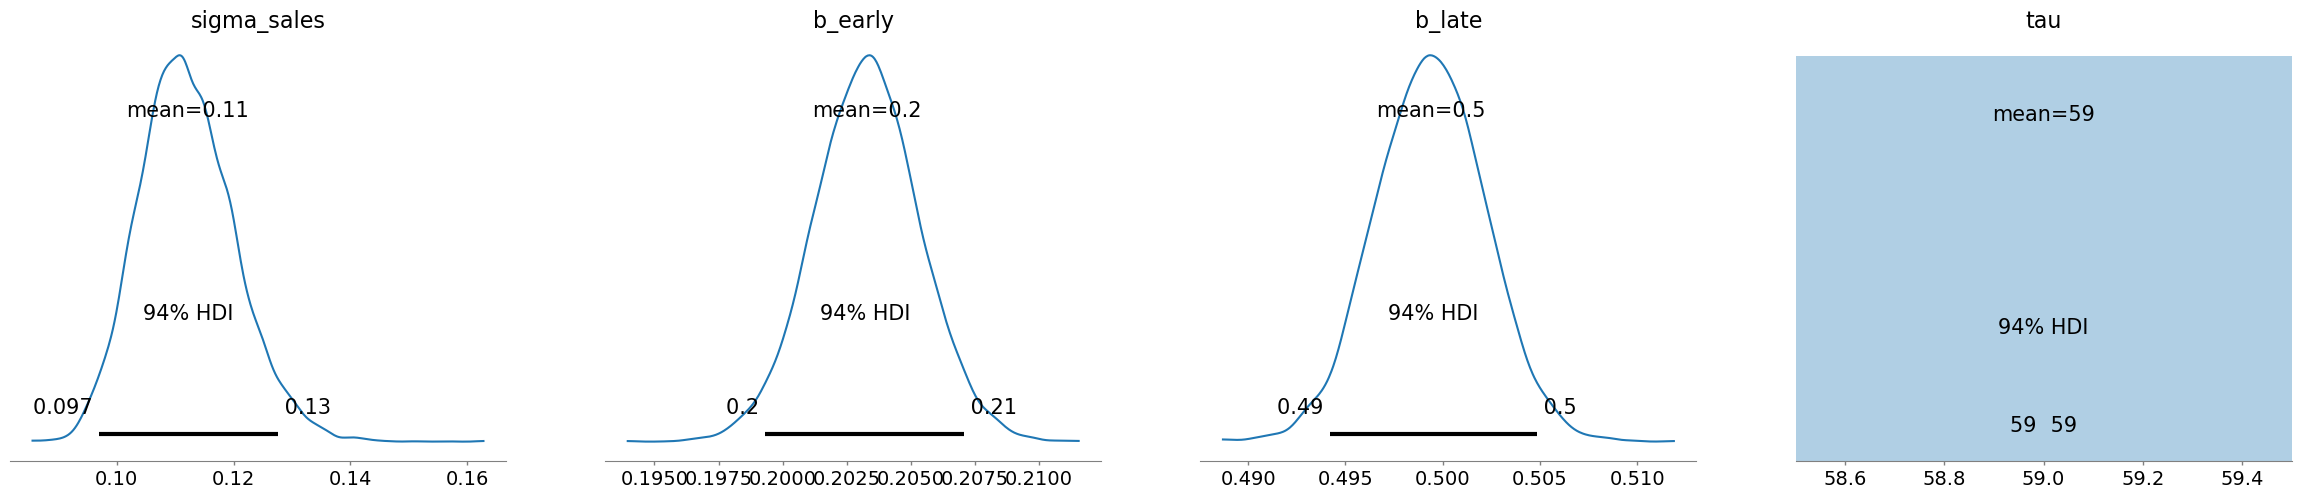

In [26]:
with pm.Model() as model:
    # Parametry modelu
    b_early = pm.Uniform("b_early", lower = 0, upper = 1)  # Wsp√≥≈Çczynnik dla dni przed 60
    b_late = pm.Uniform("b_late", lower = 0, upper = 1)  # Wsp√≥≈Çczynnik dla dni po 60

    # Punkt zmiany (dzie≈Ñ, w kt√≥rym zmienia siƒô zale≈ºno≈õƒá miƒôdzy sprzeda≈ºƒÖ a temperaturƒÖ)
    tau = pm.DiscreteUniform("tau", lower=0, upper=len(temperatures) - 1)

    # Tworzenie indeks√≥w dla dni
    idx = np.arange(len(temperatures))

    # Okre≈õlenie zale≈ºno≈õci sprzeda≈ºy od temperatury w zale≈ºno≈õci od punktu zmiany
    # Zmiana zale≈ºno≈õci sprzeda≈ºy w zale≈ºno≈õci od punktu zmiany
    b = pm.math.switch(tau < idx, b_late, b_early)

    # Modele teoretyczny sprzeda≈ºy
    # Sprzeda≈º zwiƒôksza siƒô liniowo wraz ze wzrostem temperatury powy≈ºej 25¬∞C
    # Zmienna deterministyczna, liniowo zale≈ºna od r√≥≈ºnicy miƒôdzy sta≈ÇƒÖ 25 a warto≈õciami w wektorze temperatur
    m_sales = pm.Deterministic("m_sales", b * pm.math.maximum(0, temperatures - 24))
    # m_sales = b * (temperatures - 25)
    # tzn. wraz ze wzrostem temperatury ro≈õnie sprzeda≈º zimnych napoj√≥w

    # Odchylenie standardowe (b≈ÇƒÖd w pomiarze sprzeda≈ºy)
    sigma_sales = pm.Uniform("sigma_sales", lower=0, upper=10)

    # Rozk≈Çad normalny dla obserwowanych danych sprzeda≈ºy
    sales_data = pm.Normal("sales_data", mu=m_sales, sigma=sigma_sales, observed=sales)

    # Estymacja rozk≈Çad√≥w posteriori za pomocƒÖ MCMC
    idata = pm.sample(2000, tune=2500)

az.plot_posterior(idata, var_names =["sigma_sales", "b_early", "b_late", "tau"])

In [28]:
az.summary(idata,  var_names =["sigma_sales", "b_early", "b_late", "tau"])

d:\Programy\Anaconda\envs\python3.11.7\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma_sales   0.112  0.008   0.097    0.128        0.0      0.0   10620.0   
b_early       0.203  0.002   0.199    0.207        0.0      0.0   11213.0   
b_late        0.499  0.003   0.494    0.505        0.0      0.0   11244.0   
tau          59.000  0.000  59.000   59.000        0.0      0.0    8000.0   

             ess_tail  r_hat  
sigma_sales    5846.0    1.0  
b_early        5537.0    1.0  
b_late         5840.0    1.0  
tau            8000.0    NaN

sigma_sales:

≈örednia: 0.112
Przedzia≈Ç HDI 94%: [0.097	0.128]
Model uchwyci≈Ç szum ca≈Çkiem dobrze (rzeczywisty 0.1)

ùëè_early:

≈örednia: 0.203
Przedzia≈Ç HDI 94%: [0.199, 0.207]
Wolumen sprzeda≈º w pierwszej fazie zosta≈Ç oszacowany dobrze (rzeczywisty 0.2).

ùëè_late

≈örednia: 0.499
Przedzia≈Ç HDI 94%: [0.494, 0.505]
Wolumen sprzeda≈º w drugiej fazie zosta≈Ç oszacowany dobrze (rzeczywisty 0.5).

tau (punkt zmiany fazy):

≈örednia i HDI: 59
Model ca≈Çkiem dobrze zidentyfikowa≈Ç dzie≈Ñ przej≈õcia miƒôdzy dwiema fazami (rzeczywisty 60), co ≈õwiadczy o skuteczno≈õci w wykrywaniu strukturalnych zmian w danych.